In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class HodgkinHuxleyModel:
    def __init__(self, dt=1e-3, solver="RK4"):
        self.C_m  =   1.0 # 膜容量 (uF/cm^2)
        self.g_Na = 120.0 # Na+の最大コンダクタンス (mS/cm^2)
        self.g_K  =  36.0 # K+の最大コンダクタンス (mS/cm^2)
        self.g_L  =   0.3 # 漏れイオンの最大コンダクタンス (mS/cm^2)
        self.E_Na =  50.0 # Na+の平衡電位 (mV)
        self.E_K  = -77.0 # K+の平衡電位 (mV)
        self.E_L  = -54.387 #漏れイオンの平衡電位 (mV)
        
        self.solver = solver
        self.dt = dt
        
        # V, m, h, n
        self.states = np.array([-65, 0.05, 0.6, 0.32])
        self.I_m = None
    
    def Solvers(self, func, x, dt):
        # 4th order Runge-Kutta法
        if self.solver == "RK4":
            k1 = dt*func(x)
            k2 = dt*func(x + 0.5*k1)
            k3 = dt*func(x + 0.5*k2)
            k4 = dt*func(x + k3)
            return x + (k1 + 2*k2 + 2*k3 + k4) / 6
        
        # 陽的Euler法
        elif self.solver == "Euler": 
            return x + dt*func(x)
        else:
            return None
        
    # イオンチャネルのゲートについての6つの関数
    def alpha_m(self, V):
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        return 4.0*np.exp(-(V+65.0) / 18.0)

    def alpha_h(self, V):
        return 0.07*np.exp(-(V+65.0) / 20.0)

    def beta_h(self, V):
        return 1.0/(1.0 + np.exp(-(V+35.0) / 10.0))

    def alpha_n(self, V):
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        return 0.125*np.exp(-(V+65) / 80.0)

    # Na+電流 (uA/cm^2)
    def I_Na(self, V, m, h):
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    # K+電流 (uA/cm^2)
    def I_K(self, V, n):
        return self.g_K  * n**4 * (V - self.E_K)

    # 漏れ電流 (uA/cm^2)
    def I_L(self, V):
        return self.g_L * (V - self.E_L)
        
    # 微分方程式
    def dALLdt(self, states):
        V, m, h, n = states
        
        dVdt = (self.I_m - self.I_Na(V, m, h) \
                - self.I_K(V, n) - self.I_L(V)) / self.C_m
        dmdt = self.alpha_m(V)*(1.0-m) - self.beta_m(V)*m
        dhdt = self.alpha_h(V)*(1.0-h) - self.beta_h(V)*h
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return np.array([dVdt, dmdt, dhdt, dndt])
    
    def __call__(self, I):
        self.I_m = I
        states = self.Solvers(self.dALLdt, self.states, self.dt)
        self.states = states
        return states

In [64]:
dt = 0.01
T = 400 # (ms)
td = 20 # synaptic decay time (ms)
tr = 2 # synaptic rise time (ms)
nt = round(T/dt) # ステップ数
time = np.arange(0.0, T, dt)         

# 刺激電流 (uA/cm^2)
spike = np.zeros(nt)
spike_times = [10000]
spike[spike_times] = 1

HH_neuron = HodgkinHuxleyModel(dt=dt, solver="Euler")
r = 0; hr = 0 # 初期値
X_arr = np.zeros((nt, 4)) # 記録用配列

# シミュレーション
r_list = []
for i in tqdm(range(nt)):
    r = r*(1-dt/tr) + hr*dt 
    hr = hr*(1-dt/td) + spike[i]/(tr*td)
    r_list.append(r)
    X = HH_neuron(r*50)
    X_arr[i] = X

spike = np.bitwise_and(X_arr[:-1, 0] < 0, X_arr[1:, 0] > 0)
print("Num. of spikes :", np.sum(spike))

100%|█████████████████████████████████████████████████████████████████████████| 40000/40000 [00:01<00:00, 24051.70it/s]

Num. of spikes : 0


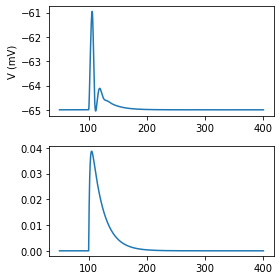

In [65]:
plt.figure(figsize=(4, 4))
plt.subplot(2,1,1)
plt.plot(time[5000:], X_arr[5000:,0])
plt.ylabel('V (mV)')

plt.subplot(2,1,2)
plt.plot(time[5000:], np.array(r_list)[5000:])
plt.tight_layout()
plt.show()

In [18]:
nt

40000